In [1]:
import random
import os
import cv2
from matplotlib import pyplot as plt
import numpy as np
import traceback

%matplotlib inline

In [2]:
images_path = "/home/aezzakri/Dvlp/py_test/drivdata/data/no_background/images"

In [3]:
def show(img_name, img):
    # cv2.namedWindow(img_name, cv2.WINDOW_NORMAL)
    # cv2.resizeWindow(img_name, 400, 300)
    # cv2.imshow(img_name, img)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    plt.imshow(img)
    plt.show()

In [4]:
def get_mask(image):
    # gray = cv2.cvtColor(image, cv2.COLOR_RGBA2GRAY)
    # _, binary = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
    # contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # mask = np.zeros_like(image[:,:,0])
    # mask = cv2.drawContours(mask, contours, -1, (255,255,255), thickness=cv2.FILLED)
    mask = image[:, :, 3]
    mask = np.where(mask > 0, 255, 0).astype(np.uint8)
    return mask

In [5]:
def get_bb(image):
    if len(image.shape) >= 3:
        if image.shape[2] >= 3:
            mask = get_mask(image)
    else:
        mask = image
    y, x = np.nonzero(mask)
    if len(x):
        xmin, xmax = np.min(x), np.max(x)
        ymin, ymax = np.min(y), np.max(y)
    else:
        if mask.any():
            print(x)
            xmin, xmax = 0, mask.shape[0]
            ymin, ymax = 0, mask.shape[1]
        else:
            print("YRDTJHGDJH")
            return None
    return xmin, ymin, xmax-xmin, ymax-ymin

In [6]:
def normalize_images(img1, img2):
    """
    This function normalizes two RGB images using histogram matching.

    Args:
        img1: The first image as a NumPy array (BGR format).
        img2: The second image as a NumPy array (BGR format).

    Returns:
        A tuple containing the normalized versions of img1 and img2 (BGR format).
    """
    # Split images into separate channels (BGR -> [B, G, R])
    b1, g1, r1 = cv2.split(img1)
    b2, g2, r2 = cv2.split(img2)

    # Perform histogram matching for each channel
    b1_norm = cv2.LUT(b1, cv2.calcHist([b2], [0], None, [256], [0,256]).flatten() / 256)
    g1_norm = cv2.LUT(g1, cv2.calcHist([g2], [0], None, [256], [0,256]).flatten() / 256)
    r1_norm = cv2.LUT(r1, cv2.calcHist([r2], [0], None, [256], [0,256]).flatten() / 256)

    # Merge normalized channels back into RGB image
    img1_normalized = cv2.merge([b1_norm, g1_norm, r1_norm])

    # Repeat for the second image
    b2_norm = cv2.LUT(b2, cv2.calcHist([b1], [0], None, [256], [0,256]).flatten() / 256)
    g2_norm = cv2.LUT(g2, cv2.calcHist([g1], [0], None, [256], [0,256]).flatten() / 256)
    r2_norm = cv2.LUT(r2, cv2.calcHist([r1], [0], None, [256], [0,256]).flatten() / 256)
    img2_normalized = cv2.merge([b2_norm, g2_norm, r2_norm])

    img1_normalized = np.clip(img1_normalized, 0, 255).astype(np.uint8)
    img2_normalized = np.clip(img2_normalized, 0, 255).astype(np.uint8)

    return img1_normalized, img2_normalized

In [7]:
def pad_images_to_match(image1, image2):
  height1, width1, channels1 = image1.shape
  height2, width2, channels2 = image2.shape

  height_diff = max(height1, height2) - min(height1, height2)
  width_diff = max(width1, width2) - min(width1, width2)

  if height1 < height2:
    top_pad = int(height_diff / 2)
    bottom_pad = height_diff - top_pad
    image1 = cv2.copyMakeBorder(image1, top_pad, bottom_pad, 0, 0, cv2.BORDER_CONSTANT, value=(0, 0, 0))  # Black padding for consistency
  else:
    top_pad = int(height_diff / 2)
    bottom_pad = height_diff - top_pad
    image2 = cv2.copyMakeBorder(image2, top_pad, bottom_pad, 0, 0, cv2.BORDER_CONSTANT, value=(0, 0, 0))

  if width1 < width2:
    left_pad = int(width_diff / 2)
    right_pad = width_diff - left_pad
    image1 = cv2.copyMakeBorder(image1, 0, 0, left_pad, right_pad, cv2.BORDER_CONSTANT, value=(0, 0, 0))
  else:
    left_pad = int(width_diff / 2)
    right_pad = width_diff - left_pad
    image2 = cv2.copyMakeBorder(image2, 0, 0, left_pad, right_pad, cv2.BORDER_CONSTANT, value=(0, 0, 0))

  return image1, image2

In [8]:
def center_resize_rotate(img, object_pos, new_size=None, angle=None):
    x, y, w, h = object_pos
    # Calculate center and offsets
    center_x = img.shape[1] // 2
    center_y = img.shape[0] // 2
    offset_x = center_x - (w // 2)
    offset_y = center_y - (h // 2)

    new_image = np.zeros_like(img)

    new_image[offset_y:offset_y+h, offset_x:offset_x+w] = img[y:y+h, x:x+w]
    
    if angle:
        rows, cols = img.shape[0], img.shape[1]
        rotation_matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1.0)
        new_image = cv2.warpAffine(new_image, rotation_matrix, (cols, rows))
        x, y, w, h = get_bb(new_image)
        offset_x = center_x - (w // 2)
        offset_y = center_y - (h // 2)
    
    return new_image[offset_y:offset_y+h, offset_x:offset_x+w]


In [9]:
def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    dim = None
    (h, w) = image.shape[:2]

    if width is None and height is None:
        return image

    if width is None:
        r = height / float(h)
        dim = (int(w * r), height)
    else:
        r = width / float(w)
        dim = (width, int(h * r))

    resized = cv2.resize(image, dim, interpolation = inter)

    return resized

In [10]:
IMAGES = [f for f in os.listdir(images_path) if os.path.isfile(os.path.join(images_path, f)) and f.lower().endswith(('.jpg', '.jpeg', '.png'))]

def random_spaceship(iter=1, seed=None):
    if seed:
        random.seed(seed)
    img_path1 = random.choice(IMAGES)
    img_path2 = random.choice(IMAGES)
    image1 = cv2.imread(os.path.join(images_path, img_path1), cv2.IMREAD_UNCHANGED)
    image2 = cv2.imread(os.path.join(images_path, img_path2), cv2.IMREAD_UNCHANGED)
    # show("a", image1)
    # show("b", image2)


    if not image2.any() or not image1.any():
        print("fail")
        return random_spaceship()
    # image1 = cv2.cvtColor(image1, cv2.COLOR_BGRA2RGBA)
    # image2 = cv2.cvtColor(image2, cv2.COLOR_BGRA2RGBA)

    angle1 = random.randrange(0, 180)
    angle2 = random.randrange(0, 180)

    new_image1 = center_resize_rotate(image1, get_bb(image1), angle=angle1)
    for _ in range(iter):
        img_path2 = random.choice(IMAGES)
        image2 = cv2.imread(os.path.join(images_path, img_path2), cv2.IMREAD_UNCHANGED)
        new_image2 = center_resize_rotate(image2, get_bb(image2), angle=angle2)

        _, _, w1, h1 = get_bb(new_image1)
        _, _, w2, h2 = get_bb(new_image2)

        # if (abs(w1*h1 - w2*h2)/(w1*h1)) >1:
        #     print("fail")
        #     continue


        if w1*h1 > w2*h2:
            new_image1 = image_resize(new_image1, height=int(max(w2, h2))) if max(h1, w1)==h1 else image_resize(new_image1, width=int(max(w2, h2)))
        else:
            new_image2 = image_resize(new_image2, height=int(max(w1, h1))) if max(h2, w2)==h2 else image_resize(new_image2, width=int(max(w1, h1)))
        
        choice = random.randint(1,2)
        size_offset = random.randrange(100, 125)/100

        if choice == 1:
            new_image1 = image_resize(new_image1, height=int(max(new_image1.shape) * size_offset))
        elif choice == 2:
            new_image2 = image_resize(new_image2, height=int(max(new_image2.shape) * size_offset))

        new_image1, new_image2 = pad_images_to_match(new_image1, new_image2)

        new_mask1 = get_mask(new_image1)//255
        new_mask2 = get_mask(new_image2)//255

        # new_image1, new_image2 = normalize_images(new_image1, new_image2)

        a = (new_mask1 + new_mask2)
        b = np.zeros([a.shape[0], a.shape[1], 4]).astype(np.float64)

        b[a==2] = np.array([0.5, 0.5, 0.5, 0.5])
        b[a==1] = np.array([1, 1, 1, 1])
        # b[a==2] = np.array([1, 1, 1, 1])

        res = np.multiply(b, new_image1.astype(np.float64)) + np.multiply(b, new_image2.astype(np.float64))

        res = res.astype(np.uint8)

        new_image1 = res

    return res, "sat.png"


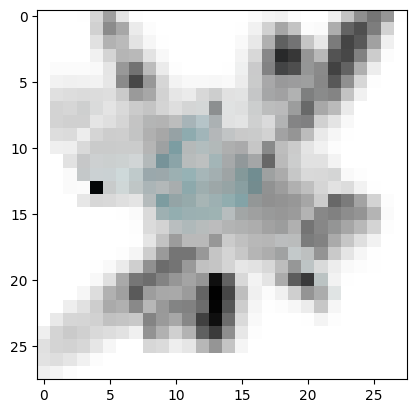

In [11]:
sat, _ = random_spaceship(iter=5)
show("space", sat)

In [12]:

def add_random_object(image, object_rgba, existing_boxes):
  """
  Adds a random object to the image without overlapping existing boxes.

  Args:
      image: The original image (numpy array).
      object_rgba: The object to be added (RGBA image array).
      existing_boxes: List of bounding boxes (xmin, ymin, xmax, ymax) for existing objects.

  Returns:
      image: The image with the added object.
      label_data: A list containing the bounding box coordinates (xmin, ymin, xmax, ymax) 
                  and class ID (assign a unique class ID for your object) of the added object.
  """
  object_h, object_w, _ = object_rgba.shape
  max_x = image.shape[1] - object_w
  max_y = image.shape[0] - object_h

  img_width, img_height, img_channels = image.shape


  while True:
    # Generate random coordinates
    rand_x = random.randint(0, max_x)
    rand_y = random.randint(0, max_y)

    # Check for overlap with existing boxes
    if not any(box[0] < rand_x + object_w and box[2] > rand_x and
               box[1] < rand_y + object_h and box[3] > rand_y for box in existing_boxes):
      # No overlap found, place the object and update label data
      roi = image[rand_y:rand_y+object_h, rand_x:rand_x+object_w]
      mask = np.where(object_rgba[:, :, 3]>0, 255, 0) // 255.0  # Extract alpha channel and normalize

      # great_mask = np.zeros_like(image[:, :, 0])

      roi = cv2.bitwise_and(roi, roi, mask=1-mask.astype(np.uint8))
      roi[:] = cv2.addWeighted(roi[:, :, :3], 1, object_rgba[:, :, :3], 1, 0.0)
      image[rand_y:rand_y+object_h, rand_x:rand_x+object_w] = roi

      # great_mask[rand_y:rand_y+object_h, rand_x:rand_x+object_w] = mask


      label_data = [0, rand_x/img_width, rand_y/img_height, (rand_x + object_w)/img_width, (rand_y + object_h)/img_height]  # Update class ID
      return image, label_data


In [13]:
def parse_label_file(label_path):
  """
  Parses a YOLOv8 TXT format label file and returns a list of bounding boxes.

  Args:
      label_path: Path to the label file.

  Returns:
      boxes: List of bounding boxes (xmin, ymin, xmax, ymax) for existing objects.
  """
  boxes = []
  with open(label_path, "r") as f:
    for line in f.readlines():
      data = line.strip().split(" ")
      class_id, xmin, ymin, xmax, ymax = map(float, data)
      boxes.append([xmin, ymin, xmax, ymax])
  return boxes

In [14]:
from utils_ import *

def transfer_style(satellite_path, background_path):
    weight = 1
    device = "cuda:0"  
    ospace = "uniform"
    resize_to = 1024

        # make 256 the smallest possible long side, will still fail if short side is <
        # if args.resize_to < 2**8:
        #     print("Resulution too low.")
        #     exit(1)

    content_pil, style_pil = pil_loader(satellite_path), pil_loader(background_path)
    content_weight = weight * 16.0

    start = time()
    result = strotss(pil_resize_long_edge_to(content_pil, resize_to), 
                    pil_resize_long_edge_to(style_pil, resize_to), content_weight, device, ospace)
    return result

/home/aezzakri/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
image_dir = "/home/aezzakri/Dvlp/py_test/drivdata/dataset_aug/images/train"
label_dir = "/home/aezzakri/Dvlp/py_test/drivdata/dataset_aug/labels/train"

i = 0
for image_path in os.listdir(image_dir):
    i += 1
    try:
        choice = random.choice([True, False, True])
        if choice:
            label_path = image_path.replace(".png", ".txt")
            image_path = os.path.join(image_dir, image_path)
            label_path = os.path.join(label_dir, label_path)
            
            background_image = cv2.imread(image_path)

            boxes = parse_label_file(label_path)

            spaceship, space_ship_path = random_spaceship(iter=random.randint(1, 4))

            image, label = add_random_object(background_image.copy(), spaceship, boxes)

    except Exception:
        print("fail")
        print(traceback.format_exc())
        continue
    
    if choice:
        print(f"Generated \t{i} images")
        print(image_path, label_path)
        # show("image", image)
        # print(" ".join(map(str, label)) + "\n")
        cv2.imwrite(image_path, image)
        with open(label_path, "a") as f:
            f.write(" ".join(map(str, label)) + "\n")  # Add new label data to file

    

Generated 	4 images
/home/aezzakri/Dvlp/py_test/drivdata/dataset_aug/images/train/155f8b6bee90b76d90dcac34defdead6.png /home/aezzakri/Dvlp/py_test/drivdata/dataset_aug/labels/train/155f8b6bee90b76d90dcac34defdead6.txt
Generated 	5 images
/home/aezzakri/Dvlp/py_test/drivdata/dataset_aug/images/train/d523dae2cfacde9ede793bc884294284.png /home/aezzakri/Dvlp/py_test/drivdata/dataset_aug/labels/train/d523dae2cfacde9ede793bc884294284.txt
Generated 	6 images
/home/aezzakri/Dvlp/py_test/drivdata/dataset_aug/images/train/e16e5eca369b17ff5da7baeaf8d38f77.png /home/aezzakri/Dvlp/py_test/drivdata/dataset_aug/labels/train/e16e5eca369b17ff5da7baeaf8d38f77.txt
Generated 	7 images
/home/aezzakri/Dvlp/py_test/drivdata/dataset_aug/images/train/71d0bd3225348ec3cdbc96e511b48db1.png /home/aezzakri/Dvlp/py_test/drivdata/dataset_aug/labels/train/71d0bd3225348ec3cdbc96e511b48db1.txt
Generated 	9 images
/home/aezzakri/Dvlp/py_test/drivdata/dataset_aug/images/train/c5e7e482a2266650bb1e61caeebeb6c6.png /home/aez

In [47]:
background_image.shape

(1024, 1280, 3)

### Dev

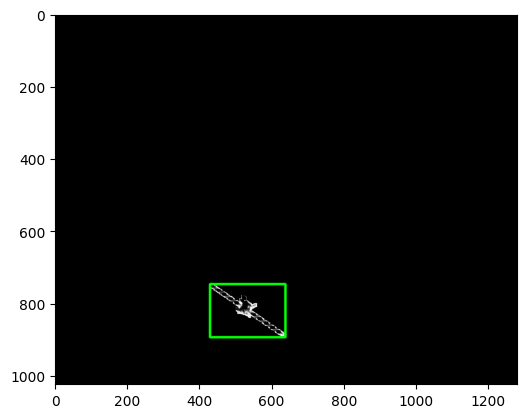

In [ ]:
x, y, w, h = get_bb(image1)
plt.imshow(cv2.rectangle(image1.copy(),(x,y),(x+w,y+h),(0,255,0),5))
plt.show()

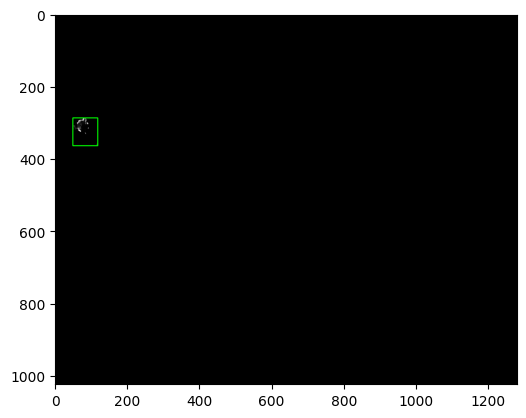

In [ ]:
x, y, w, h = get_bb(image2)
plt.imshow(cv2.rectangle(image2.copy(), (x,y),(x+w,y+h),(0,255,0),2))
plt.show()

In [14]:
new_image1 = center_resize_rotate(image1, get_bb(image1), angle=90)
new_image2 = center_resize_rotate(image2, get_bb(image2), angle=0)

NameError: name 'image1' is not defined

In [15]:
_, _, w1, h1 = get_bb(image1)
_, _, w2, h2 = get_bb(image2)

size_offset = random.randrange(50, 150)/100

if w1*h1 > w2*h2:
    new_image2 = image_resize(new_image2, height=int(max(w1, h1)*size_offset)) if max(h2, w2)==h2 else image_resize(new_image2, width=int(max(w1, h1)*size_offset))
else:
    new_image1 = image_resize(new_image1, height=int(max(w2, h2)*size_offset)) if max(h1, w1)==h1 else image_resize(new_image1, width=int(max(w2, h2)*size_offset))

NameError: name 'image1' is not defined

In [16]:
choice = random.randint(1,2)

size_offset = random.randrange(100, 150)/100

if choice == 1:
    new_image1 = image_resize(new_image1, height=int(new_image1.shape[1] * size_offset))
elif choice == 2:
    new_image2 = image_resize(new_image2, height=int(new_image2.shape[1] * size_offset))



NameError: name 'new_image1' is not defined

In [17]:
new_image1, new_image2 = pad_images_to_match(new_image1, new_image2)

NameError: name 'new_image1' is not defined

In [18]:
new_image1.shape, new_image2.shape

NameError: name 'new_image1' is not defined

In [19]:
new_mask1 = get_mask(new_image1)
new_mask2 = get_mask(new_image2)

NameError: name 'new_image1' is not defined

In [20]:
a = (new_mask1 + new_mask2)
b = np.zeros([a.shape[0], a.shape[1], 3]).astype(np.float64)

b[a==2] = np.array([0.5, 0.5, 0.5])
b[a==1] = np.array([1, 1, 1])

res = np.multiply(b, new_image1.astype(np.float64)) + np.multiply(b, new_image2.astype(np.float64))

NameError: name 'new_mask1' is not defined

In [29]:
cv2.imwrite("res.png", res)

True

In [23]:
background_image = cv2.imread("/home/aezzakri/Dvlp/py_test/drivdata/data/0/images/0a0ba7d4c31cd8c12e66f3e792a9599f.png")
background_image = cv2.cvtColor(background_image, cv2.COLOR_BGR2RGB)

In [24]:
new_image1.shape

(208, 146, 3)

In [25]:
background_image.shape

(1024, 1280, 3)

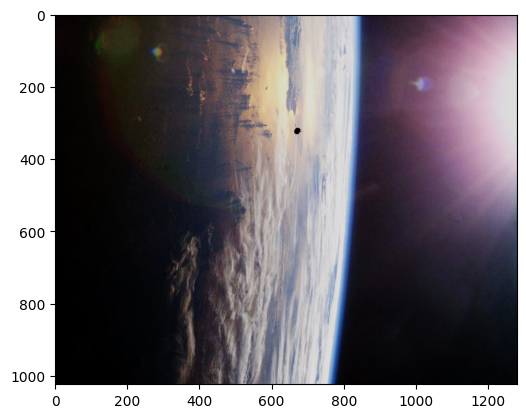

In [26]:
show("aa", background_image)